In [1]:
# %matplotlib widget
# %matplotlib notebook
from itertools import product, combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
from scipy.signal import correlate, correlation_lags
from scipy.signal import find_peaks, peak_prominences
from lmfit import Model, minimize

from pysmog.data_loading import load_defra_file
from pysmog.data_processing import bin_data
from pysmog.plot_utils import set_matplotlib_defaults
from pysmog.psd import lorentzian, log_lorentzian

In [2]:
set_matplotlib_defaults()

In [3]:
data_tower_hamlets = '../data/2022-01-01-230802122803.csv'
data_tower_soton = '../data/2022-01-01-230802132242.csv'

df  = load_defra_file(data_tower_hamlets)
df2 = load_defra_file(data_tower_soton)

In [4]:
df_numeric = df2.select_dtypes(include='number')
#df_numeric = df_numeric.fillna(0)
#df_numeric = df_numeric.dropna()
df_numeric = df_numeric.interpolate()

# Cross-Correlation.
The cross-correlation is a measure of similarity between two time series.

Cross-correlation for continuous functions $f$ and $g$ is
defined as:


$$
\left ( f\star g \right )\left ( \tau \right )
\triangleq \int_{t_0}^{t_0 +T}
\overline{f\left ( t \right )}g\left ( t+\tau \right )dt
$$
Where $\tau$ is defined as the displacement, also known as the lag. 


Cross correlation for discrete functions $f$ and $g$ is
defined as:

$$
        \left ( f\star g \right )\left [ n \right ]
        \triangleq \sum_{-\infty}^{\infty}
        \overline{f\left [ m \right ]}g\left [ m+n \right ]
$$
Where $n$ is the lag.

Calculating the cross-correlation for a light curve with itself is known as an auto-correlation function and gives a measure
of the effictive coherence timescales in the data.

In python an implementation of the cross-correlation function is implemented in `scipy.signal.correlate`
while the lag indices may be calculated using `scipy.signal.correlation_lags`

In [5]:
df_numeric = df_numeric.drop('t',axis=1)
xdata = df_numeric['NO'].values
ydata = df_numeric['NO2'].values

res = correlate(xdata, ydata, mode='full', method='auto')
lags = correlation_lags(len(xdata), len(ydata))

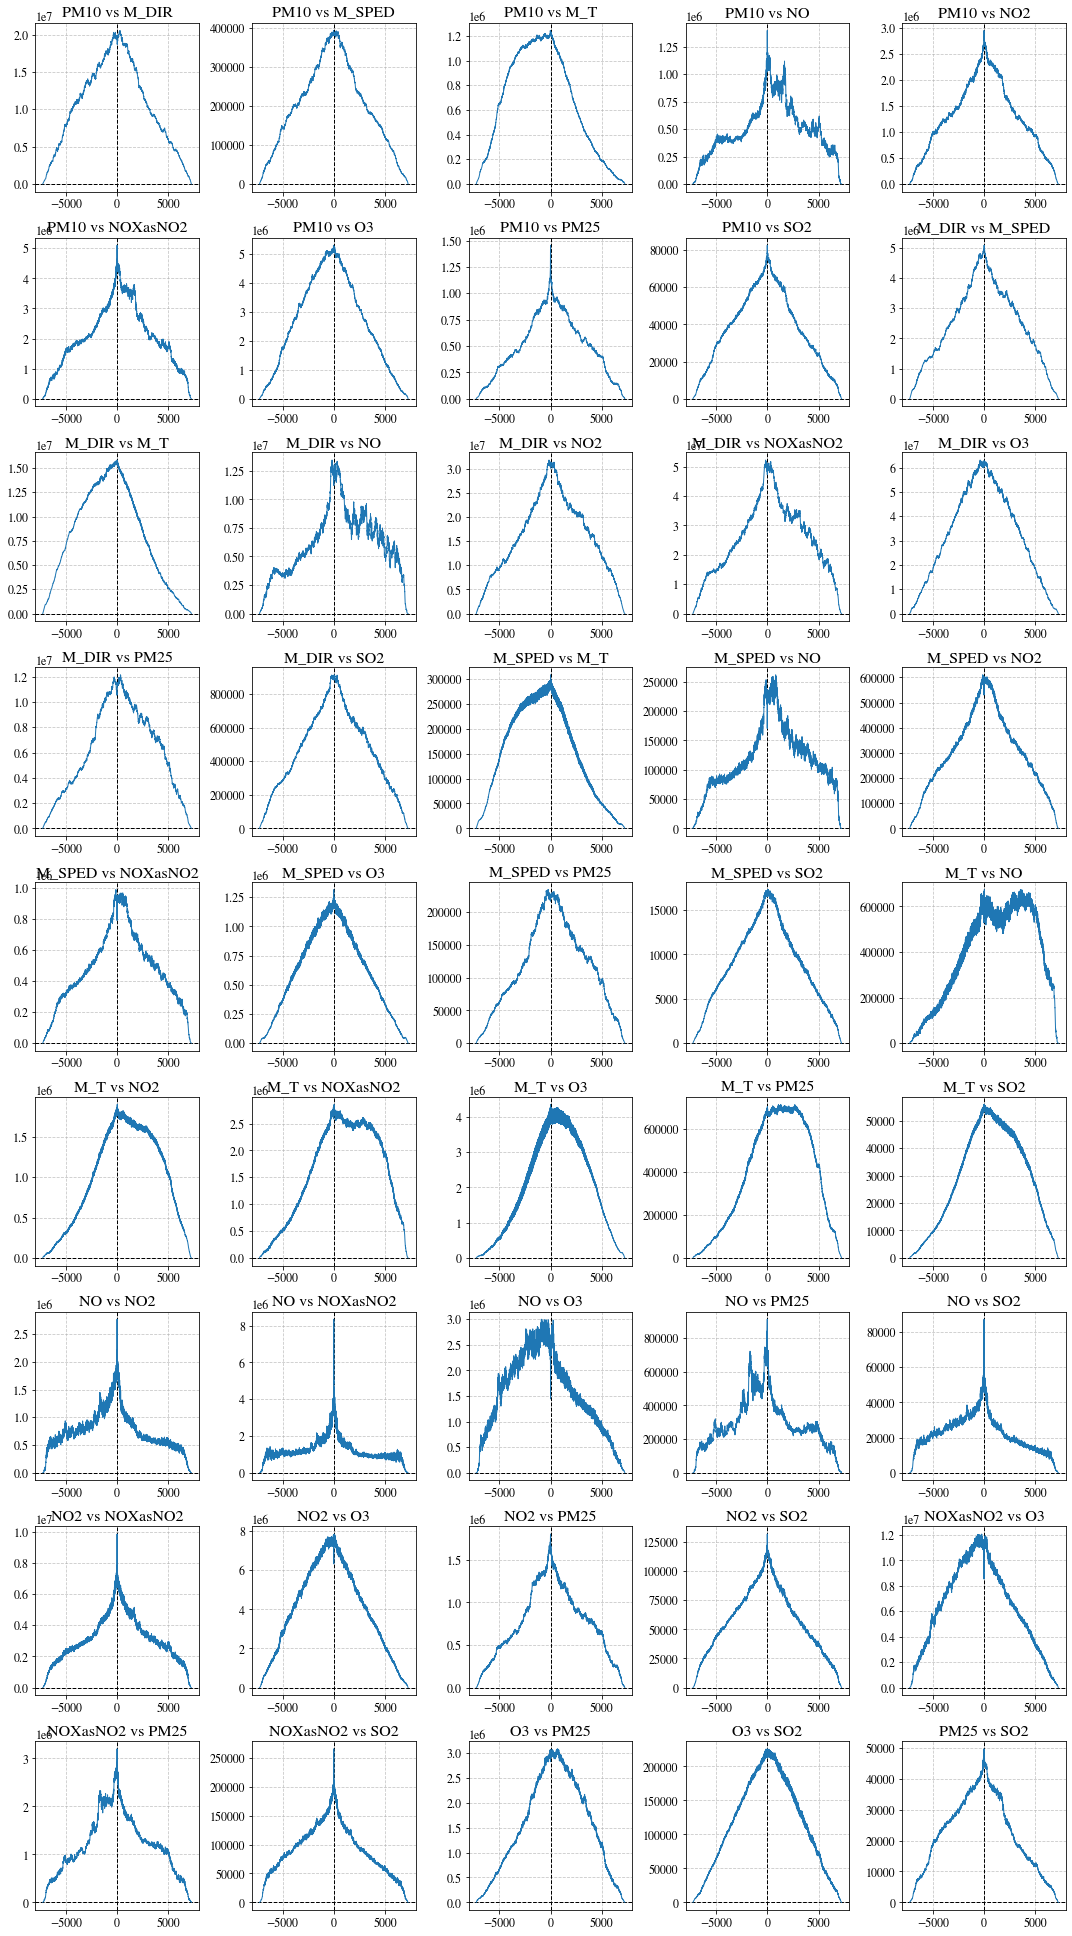

In [6]:
nrows = 9
ncols = 5
fig_width = 15
fig_height = fig_width * (nrows/ncols)
fig, ax = plt.subplots(nrows,ncols, figsize=(fig_width, fig_height))

i = 0
for col1, col2 in combinations(df_numeric.columns, r=2):
    xdata = df_numeric[col1].values
    ydata = df_numeric[col2].values

    res = correlate(xdata, ydata, mode='full', method='auto')
    lags = correlation_lags(len(xdata), len(ydata))
    
    
    #plt.figure(figsize=(6,6))
    axes = ax.flatten()[i]
    
    axes.set_title(f'{col1} vs {col2}')
    axes.axvline(0, color='black', ls='--')
    axes.axhline(0, color='black', ls='--')
    axes.plot(lags,res)
    
    i+=1
plt.tight_layout()

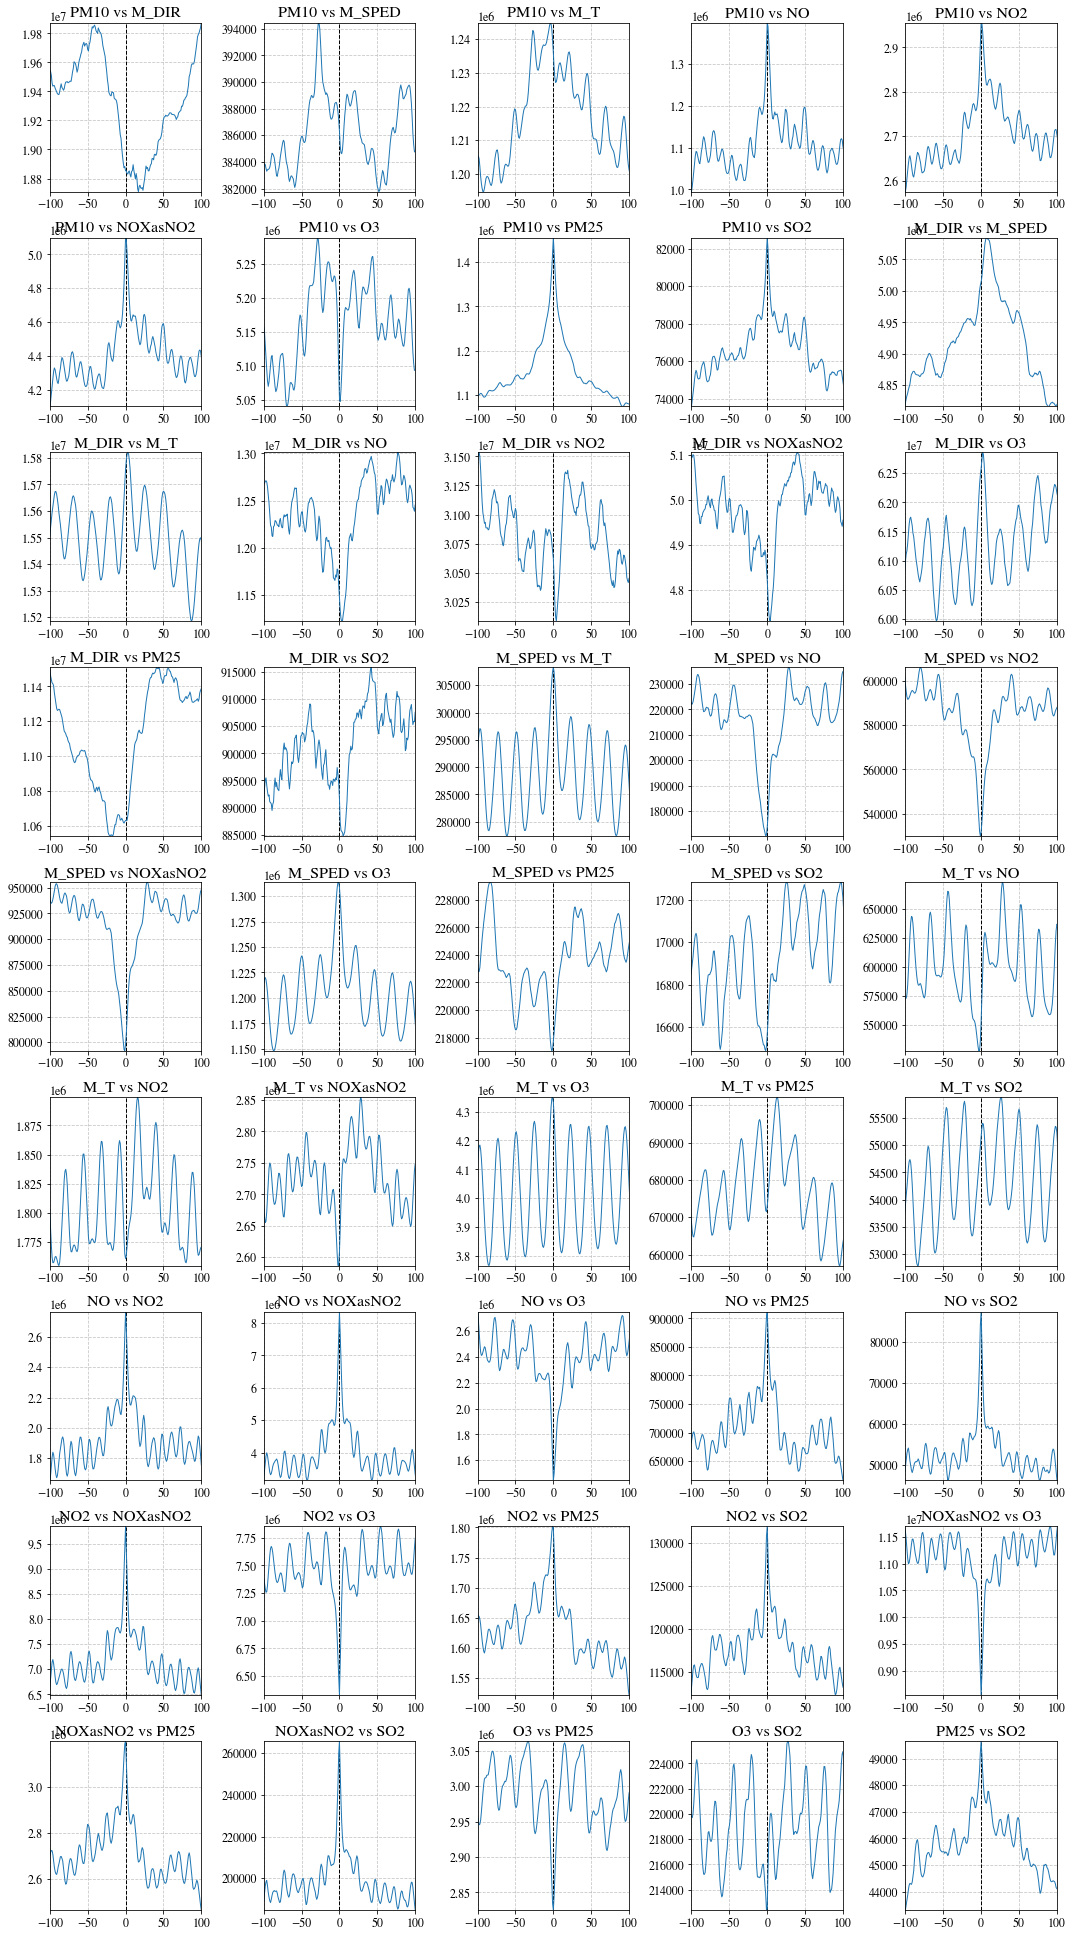

In [7]:
nrows = 9
ncols = 5
fig_width = 15
fig_height = fig_width * (nrows/ncols)
fig, ax = plt.subplots(nrows,ncols, figsize=(fig_width, fig_height))

i = 0
for col1, col2 in combinations(df_numeric.columns, r=2):
    xdata = df_numeric[col1].values
    ydata = df_numeric[col2].values

    res = correlate(xdata, ydata, mode='full', method='auto')
    lags = correlation_lags(len(xdata), len(ydata))
    
    
    #plt.figure(figsize=(6,6))
    axes = ax.flatten()[i]
    
    axes.set_title(f'{col1} vs {col2}')
    axes.axvline(0, color='black', ls='--')
    axes.axhline(0, color='black', ls='--')
    axes.plot(lags,res)
    
    x_min, x_max = -100, 100
    x_indices = (lags >= x_min) & (lags <= x_max)
    y_min, y_max = min(res[x_indices]), max(res[x_indices])
    axes.set_ylim(y_min, y_max)
    axes.set_xlim(x_min, x_max)
    
    
    i+=1
plt.tight_layout()

In [8]:
# Creating Averaged Periodograms and CCFs.
# Splitting the time series into chunks
xdata = df_numeric['NO'].values
ydata = df_numeric['NO2'].values

res = correlate(xdata, ydata, mode='full', method='auto')
lags = correlation_lags(len(xdata), len(ydata))

# Split Data into N equal sized segments
N_splits = 13
N_data = len(xdata)
split_length = N_data // N_splits
print(N_splits, N_data, split_length)
print('')
split_start = 0
split_end = split_length
for i in range(1, N_splits+1):
    split_start = (i - 1) * split_length
    split_end   = i * split_length
    
    data_split = xdata[split_start:split_end]
    print(f'Segment {i}: Start index: {split_start}, End index: {split_end}, Length: {len(data_split)}')

13 7248 557

Segment 1: Start index: 0, End index: 557, Length: 557
Segment 2: Start index: 557, End index: 1114, Length: 557
Segment 3: Start index: 1114, End index: 1671, Length: 557
Segment 4: Start index: 1671, End index: 2228, Length: 557
Segment 5: Start index: 2228, End index: 2785, Length: 557
Segment 6: Start index: 2785, End index: 3342, Length: 557
Segment 7: Start index: 3342, End index: 3899, Length: 557
Segment 8: Start index: 3899, End index: 4456, Length: 557
Segment 9: Start index: 4456, End index: 5013, Length: 557
Segment 10: Start index: 5013, End index: 5570, Length: 557
Segment 11: Start index: 5570, End index: 6127, Length: 557
Segment 12: Start index: 6127, End index: 6684, Length: 557
Segment 13: Start index: 6684, End index: 7241, Length: 557
